<a href="https://colab.research.google.com/github/rodrigosimass/mnist_FFNN_CNN/blob/master/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import KFold
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

In [0]:
mnist_data, mnist_info = tfds.load('mnist', with_info=True)
mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])
mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

Manual separation into train and validation:

In [3]:
"""val_x, mnist_train_x = np.split(mnist_train_x,[10000])
val_y, mnist_train_y = np.split(mnist_train_y,[10000])
val_set = (val_x,val_y)"""

'val_x, mnist_train_x = np.split(mnist_train_x,[10000])\nval_y, mnist_train_y = np.split(mnist_train_y,[10000])\nval_set = (val_x,val_y)'

# Baseline
No hidden 

In [4]:
mnist_baseline_model = tf.keras.Sequential(name='mnist_baseline')
mnist_baseline_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_baseline_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_baseline_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_baseline_model.summary()

Model: "mnist_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [5]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_baseline_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_baseline_model_train = mnist_baseline_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 1.6875 - accuracy: 0.5556
Epoch 00001: val_accuracy improved from -inf to 0.75017, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 5ms/step - loss: 1.6875 - accuracy: 0.5556 - val_loss: 1.2538 - val_accuracy: 0.7502
Epoch 2/10000
176/188 [===========================>..] - ETA: 0s - loss: 1.0729 - accuracy: 0.7803
Epoch 00002: val_accuracy improved from 0.75017 to 0.80417, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 1.0635 - accuracy: 0.7819 - val_loss: 0.9255 - val_accuracy: 0.8042
Epoch 3/10000
177/188 [===========================>..] - ETA: 0s - loss: 0.8461 - accuracy: 0.8170
Epoch 00003: val_accuracy improved from 0.80417 to 0.82792, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.8420 - accuracy: 0.8181 - val_loss: 0.7782 - val_accuracy: 0.8279
Epoch 4/10000
18

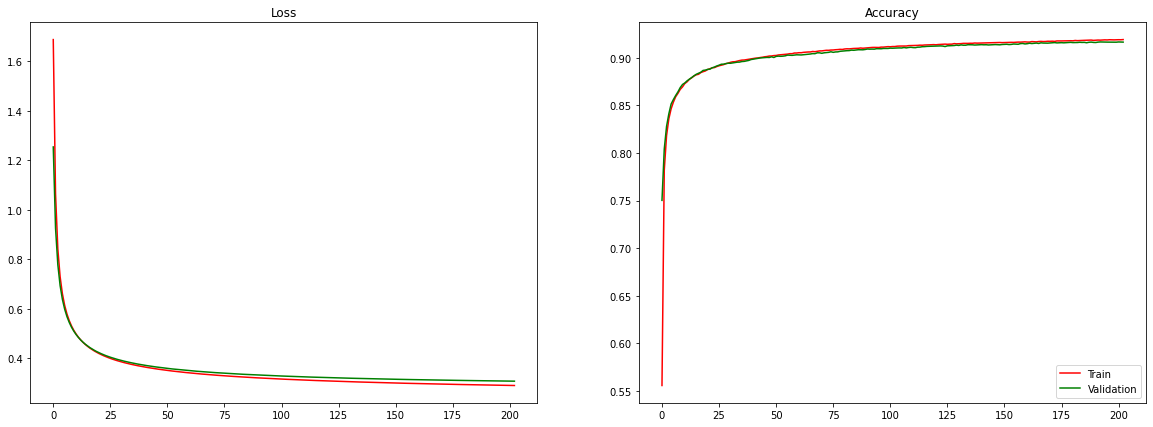

In [6]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_baseline_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_baseline_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_baseline_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_baseline_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

Convolutional 1 hidden Layer

In [0]:
def isBest(result, results):
  if(len(results)==0):
    return True
  if(result>max(results)):
    return True
  return False

#MLP

In [0]:
num_hidden_layers = [1,2,3]
num_hidden_neurons = [50,100,150,200]
num_folds = 5; #cross validation
eps = 10000 #epochs

for layers in num_hidden_layers:
    print("\n\nhidden_layers=",layers)
    for num_neur in num_hidden_neurons:
        kf = KFold(n_splits=num_folds)
        results = []
        i = 1
        print("    num_neurons:",num_neur)
        for train_idx, val_idx in kf.split(mnist_train_x, mnist_train_y):
            #print("fold",i,"/",num_folds)
            i+=1
            #SPLIT THE DATA
            train_x = mnist_train_x[train_idx]
            train_y = mnist_train_y[train_idx]
            val_x = mnist_train_x[val_idx]
            val_y = mnist_train_y[val_idx]
            val_set = (val_x, val_y)

            #BUILD THE NN
            mlp = tf.keras.Sequential(name='MLP-1HU')
            mlp.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
            mlp.add(tf.keras.layers.Flatten(name='flatten'))
            for i in range (layers):
                nm = "HU" + str(i)
                #print(nm, " unit added")
                mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name=nm))
            mlp.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

            mlp.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

            #DEFINE CALL BACKS
            earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
            checkpoint_train = tf.keras.callbacks.ModelCheckpoint('MLP-1HU.h5', monitor='accuracy', verbose=0, save_best_only=True)
            checkpoint_valid = tf.keras.callbacks.ModelCheckpoint('multi_layer_2.h5', monitor='val_accuracy', verbose=0, save_best_only=True)

            #TRAIN
            mlp_train = mlp.fit(mnist_train_x, mnist_train_y, validation_data= val_set, callbacks=[earlystop,checkpoint_train,checkpoint_valid], epochs=eps, batch_size=256, verbose=0)

            #ASSESS PERFORMANCE
            mlp.load_weights('multi_layer_2.h5')
            if(isBest(checkpoint_valid.best,results)):
                #SAVE MODEL OF BEST FOLD
                #mlp.save_weights('best_MLP.h5')
                #best_train = mlp_train
                best_val = checkpoint_valid.best
                best_train = checkpoint_train.best
            results.append(checkpoint_valid.best);
            
        #print(results)
        #mlp.load_weights('best_MLP.h5')
        print("        val:",best_val," trn:",best_train)



hidden_layers= 1
    num_neurons: 50
Epoch 00323: early stopping
Epoch 00363: early stopping
Epoch 00649: early stopping
Epoch 00384: early stopping
Epoch 00364: early stopping
        val: 0.987416684627533  trn: 0.9868500232696533
    num_neurons: 100
Epoch 00453: early stopping
Epoch 00564: early stopping
Epoch 00458: early stopping
Epoch 00516: early stopping
Epoch 00427: early stopping
        val: 0.9891666769981384  trn: 0.9885833263397217
    num_neurons: 150
Epoch 00695: early stopping
Epoch 00538: early stopping
Epoch 00617: early stopping
Epoch 00659: early stopping
Epoch 00456: early stopping
        val: 0.9926666617393494  trn: 0.993233323097229
    num_neurons: 200
Epoch 00484: early stopping
Epoch 00593: early stopping
Epoch 00474: early stopping
Epoch 00422: early stopping
Epoch 00494: early stopping
        val: 0.9919999837875366  trn: 0.9910833239555359


hidden_layers= 2
    num_neurons: 50
Epoch 00265: early stopping
Epoch 00399: early stopping
Epoch 00392: earl

In [9]:
"""mlp.load_weights('best_MLP.h5')
#loss, acc = mlp.evaluate(mnist_test_x, mnist_test_y)
print("All folds:")
print(results)
print("\nBest Model:")
print("Accuracy:")
print(' -TEST      : {}'.format(acc))
print(" -validation:",checkpoint_valid.best)
print(" -train     :",checkpoint_train.best)"""

'mlp.load_weights(\'best_MLP.h5\')\n#loss, acc = mlp.evaluate(mnist_test_x, mnist_test_y)\nprint("All folds:")\nprint(results)\nprint("\nBest Model:")\nprint("Accuracy:")\nprint(\' -TEST      : {}\'.format(acc))\nprint(" -validation:",checkpoint_valid.best)\nprint(" -train     :",checkpoint_train.best)'

In [10]:
"""fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(best_train.history['loss'], '-r', label='Train')
loss_ax.plot(best_train.history['val_loss'], '-g', label='Validation')
acc_ax.set_title('Accuracy')
acc_ax.plot(best_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(best_train.history['val_accuracy'], '-g', label='Validation')
plt.legend(loc=4)
plt.show()"""

"fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))\n\nloss_ax.set_title('Loss')\nloss_ax.plot(best_train.history['loss'], '-r', label='Train')\nloss_ax.plot(best_train.history['val_loss'], '-g', label='Validation')\nacc_ax.set_title('Accuracy')\nacc_ax.plot(best_train.history['accuracy'], '-r', label='Train')\nacc_ax.plot(best_train.history['val_accuracy'], '-g', label='Validation')\nplt.legend(loc=4)\nplt.show()"

# MLP 2 hidden Layer


In [18]:
name = "HU"
name += str(1)
print(name)

HU1


In [15]:
for num_neur in num_hidden_neurons:
    kf = KFold(n_splits=num_folds)
    results = []
    i = 1
    print("\n-----num_neurons:",num_neur,"-----")
    for train_idx, val_idx in kf.split(mnist_train_x, mnist_train_y):
        #print("fold",i,"/",num_folds)
        i+=1
        #SPLIT THE DATA
        train_x = mnist_train_x[train_idx]
        train_y = mnist_train_y[train_idx]
        val_x = mnist_train_x[val_idx]
        val_y = mnist_train_y[val_idx]
        val_set = (val_x, val_y)

        #BUILD THE NN
        mlp = tf.keras.Sequential(name='MLP-1HU')
        mlp.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
        mlp.add(tf.keras.layers.Flatten(name='flatten'))
        mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name='HU1'))
        mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name='HU1'))
        mlp.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

        mlp.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        #DEFINE CALL BACKS
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
        checkpoint_train = tf.keras.callbacks.ModelCheckpoint('MLP-1HU.h5', monitor='accuracy', verbose=0, save_best_only=True)
        checkpoint_valid = tf.keras.callbacks.ModelCheckpoint('multi_layer_2.h5', monitor='val_accuracy', verbose=0, save_best_only=True)

        #TRAIN
        mlp_train = mlp.fit(mnist_train_x, mnist_train_y, validation_data= val_set, callbacks=[earlystop,checkpoint_train,checkpoint_valid], epochs=eps, batch_size=256, verbose=0)

        #ASSESS PERFORMANCE
        mlp.load_weights('multi_layer_2.h5')
        if(isBest(checkpoint_valid.best,results)):
            #SAVE MODEL OF BEST FOLD
            #mlp.save_weights('best_MLP.h5')
            #best_train = mlp_train
            best_val = checkpoint_valid.best
            best_train = checkpoint_train.best
        results.append(checkpoint_valid.best);
        
    #print(results)
    #mlp.load_weights('best_MLP.h5')
    print("val:",best_val," trn:",best_train)


-----num_neurons: 1 -----


ValueError: ignored

In [12]:
for num_neur in num_hidden_neurons:
    kf = KFold(n_splits=num_folds)
    results = []
    i = 1
    print("\n-----num_neurons:",num_neur,"-----")
    for train_idx, val_idx in kf.split(mnist_train_x, mnist_train_y):
        #print("fold",i,"/",num_folds)
        i+=1
        #SPLIT THE DATA
        train_x = mnist_train_x[train_idx]
        train_y = mnist_train_y[train_idx]
        val_x = mnist_train_x[val_idx]
        val_y = mnist_train_y[val_idx]
        val_set = (val_x, val_y)

        #BUILD THE NN
        mlp = tf.keras.Sequential(name='MLP-1HU')
        mlp.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
        mlp.add(tf.keras.layers.Flatten(name='flatten'))
        mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name='HU1'))
        mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name='HU2'))
        mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name='HU3'))
        mlp.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

        mlp.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        #DEFINE CALL BACKS
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
        checkpoint_train = tf.keras.callbacks.ModelCheckpoint('MLP-1HU.h5', monitor='accuracy', verbose=0, save_best_only=True)
        checkpoint_valid = tf.keras.callbacks.ModelCheckpoint('multi_layer_2.h5', monitor='val_accuracy', verbose=0, save_best_only=True)

        #TRAIN
        mlp_train = mlp.fit(mnist_train_x, mnist_train_y, validation_data= val_set, callbacks=[earlystop,checkpoint_train,checkpoint_valid], epochs=eps, batch_size=256, verbose=0)

        #ASSESS PERFORMANCE
        mlp.load_weights('multi_layer_2.h5')
        if(isBest(checkpoint_valid.best,results)):
            #SAVE MODEL OF BEST FOLD
            #mlp.save_weights('best_MLP.h5')
            #best_train = mlp_train
            best_val = checkpoint_valid.best
            best_train = checkpoint_train.best
        results.append(checkpoint_valid.best);
        
    #print(results)
    #mlp.load_weights('best_MLP.h5')
    print("val:",best_val," trn:",best_train)


-----num_neurons: 1 -----
val: 0.20576666295528412  trn: 0.2056666612625122

-----num_neurons: 2 -----
val: 0.3002333343029022  trn: 0.28415000438690186

-----num_neurons: 3 -----
val: 0.37726667523384094  trn: 0.36861667037010193

-----num_neurons: 4 -----
val: 0.43613332509994507  trn: 0.3853333294391632


# MLP 1 Convulutional Layer

In [13]:
''' tf.random.set_seed(1) #to ensure same data split for all models

conv_model = tf.keras.Sequential(name='mnist_cnn')
conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
conv_model.add(tf.keras.layers.Flatten(name='flatten'))
conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

conv_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
conv_checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_conv_model_train = conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2,
                                        callbacks=[conv_earlystop,conv_checkpoint], 
                                        epochs=10000, batch_size=256) '''


" tf.random.set_seed(1) #to ensure same data split for all models\n\nconv_model = tf.keras.Sequential(name='mnist_cnn')\nconv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))\nconv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))\nconv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))\nconv_model.add(tf.keras.layers.Flatten(name='flatten'))\nconv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))\nconv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])\n\nconv_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)\nconv_checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)\n\nmnist_conv_model_train = conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2,\n        

In [14]:
''' fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_conv_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_conv_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_conv_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_conv_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show() '''

" fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))\n\nloss_ax.set_title('Loss')\nloss_ax.plot(mnist_conv_model_train.history['loss'], '-r', label='Train')\nloss_ax.plot(mnist_conv_model_train.history['val_loss'], '-g', label='Validation')\n\nacc_ax.set_title('Accuracy')\nacc_ax.plot(mnist_conv_model_train.history['accuracy'], '-r', label='Train')\nacc_ax.plot(mnist_conv_model_train.history['val_accuracy'], '-g', label='Validation')\n\nplt.legend(loc=4)\nplt.show() "